In [3]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
password = getpass.getpass()

In [4]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

### 1- Create an SQL query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features

In [5]:
df1 = pd.read_sql_table('film', engine)
df2 = pd.read_sql_table('rental', engine)

/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:320: SAWarning: Did not recognize type 'geometry' of column 'location'
  meta.reflect(only=[table_name], views=True)


### 2- Read the data into a Pandas dataframe

In [6]:
data = pd.concat([df1,df2], axis=1)
data

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update
0,1.0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006.0,1.0,None,6.0,0.99,86.0,20.99,PG,"{Behind the Scenes, Deleted Scenes}",2006-02-15 05:03:42,1,2005-05-24 22:53:30,367,130,2005-05-26 22:04:30,1,2006-02-15 21:30:53
1,2.0,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006.0,1.0,None,3.0,4.99,48.0,12.99,G,"{Trailers, Deleted Scenes}",2006-02-15 05:03:42,2,2005-05-24 22:54:33,1525,459,2005-05-28 19:40:33,1,2006-02-15 21:30:53
2,3.0,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006.0,1.0,None,7.0,2.99,50.0,18.99,NC-17,"{Trailers, Deleted Scenes}",2006-02-15 05:03:42,3,2005-05-24 23:03:39,1711,408,2005-06-01 22:12:39,1,2006-02-15 21:30:53
3,4.0,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006.0,1.0,None,5.0,2.99,117.0,26.99,G,"{Behind the Scenes, Commentaries}",2006-02-15 05:03:42,4,2005-05-24 23:04:41,2452,333,2005-06-03 01:43:41,2,2006-02-15 21:30:53
4,5.0,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,2006.0,1.0,None,6.0,2.99,130.0,22.99,G,{Deleted Scenes},2006-02-15 05:03:42,5,2005-05-24 23:05:21,2079,222,2005-06-02 04:33:21,1,2006-02-15 21:30:53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,16045,2005-08-23 22:25:26,772,14,2005-08-25 23:54:26,1,2006-02-15 21:30:53
16040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,16046,2005-08-23 22:26:47,4364,74,2005-08-27 18:02:47,2,2006-02-15 21:30:53
16041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,16047,2005-08-23 22:42:48,2088,114,2005-08-25 02:48:48,2,2006-02-15 21:30:53
16042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,16048,2005-08-23 22:43:07,2019,103,2005-08-31 21:33:07,1,2006-02-15 21:30:53


In [7]:
data = data.drop(columns=['language_id', 'description', 'special_features', 'inventory_id', 'staff_id', 'film_id', 'customer_id', 'last_update', 'original_language_id'])
data

,title,release_year,rental_duration,rental_rate,length,replacement_cost,rating,rental_id,rental_date,return_date
0,ACADEMY DINOSAUR,2006.0,6.0,0.99,86.0,20.99,PG,1,2005-05-24 22:53:30,2005-05-26 22:04:30
1,ACE GOLDFINGER,2006.0,3.0,4.99,48.0,12.99,G,2,2005-05-24 22:54:33,2005-05-28 19:40:33
2,ADAPTATION HOLES,2006.0,7.0,2.99,50.0,18.99,NC-17,3,2005-05-24 23:03:39,2005-06-01 22:12:39
3,AFFAIR PREJUDICE,2006.0,5.0,2.99,117.0,26.99,G,4,2005-05-24 23:04:41,2005-06-03 01:43:41
4,AFRICAN EGG,2006.0,6.0,2.99,130.0,22.99,G,5,2005-05-24 23:05:21,2005-06-02 04:33:21
...,...,...,...,...,...,...,...,...,...,...
16039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16045,2005-08-23 22:25:26,2005-08-25 23:54:26
16040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16046,2005-08-23 22:26:47,2005-08-27 18:02:47
16041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16047,2005-08-23 22:42:48,2005-08-25 02:48:48
16042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16048,2005-08-23 22:43:07,2005-08-31 21:33:07


### 3- Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables

In [8]:
data.shape

(16044, 10)

In [9]:
data.dtypes

title                       object
release_year               float64
rental_duration            float64
rental_rate                float64
length                     float64
replacement_cost           float64
rating                      object
rental_id                    int64
rental_date         datetime64[ns]
return_date         datetime64[ns]
dtype: object

In [10]:
data.describe()

,release_year,rental_duration,rental_rate,length,replacement_cost,rental_id
count,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,16044.000000
mean,2006.0,4.985000,2.980000,115.272000,19.984000,8025.371478
std,0.0,1.411654,1.646393,40.426332,6.050833,4632.777249
min,2006.0,3.000000,0.990000,46.000000,9.990000,1.000000
25%,2006.0,4.000000,0.990000,80.000000,14.990000,4013.750000
50%,2006.0,5.000000,2.990000,114.000000,19.990000,8025.500000
75%,2006.0,6.000000,4.990000,149.250000,24.990000,12037.250000
max,2006.0,7.000000,4.990000,185.000000,29.990000,16049.000000


In [11]:
data.isna().sum()

title               15044
release_year        15044
rental_duration     15044
rental_rate         15044
length              15044
replacement_cost    15044
rating              15044
rental_id               0
rental_date             0
return_date           183
dtype: int64

In [12]:
data = data.fillna(0)


In [13]:
for col in data.select_dtypes('object'):
    print(data[col].value_counts(), '\n')

0                    15044
PERSONAL LADYBUGS        1
PARTY KNOCK              1
PAST SUICIDES            1
PATHS CONTROL            1
                     ...  
FRONTIER CABIN           1
FROST HEAD               1
FUGITIVE MAGUIRE         1
FULL FLATLINERS          1
KISSING DOLLS            1
Name: title, Length: 1001, dtype: int64 

0        15044
PG-13      223
NC-17      210
R          195
PG         194
G          178
Name: rating, dtype: int64 

0                      183
2005-08-02 22:15:17      2
2005-06-03 06:05:10      2
2005-08-25 05:03:52      2
2005-06-21 21:54:15      2
                      ... 
2005-07-15 18:09:09      1
2005-07-14 19:29:06      1
2005-07-18 15:59:36      1
2005-07-15 19:02:45      1
2005-08-30 01:01:12      1
Name: return_date, Length: 15837, dtype: int64 



In [14]:
data.head

<bound method NDFrame.head of                   title  release_year  rental_duration  rental_rate  length  \
0      ACADEMY DINOSAUR        2006.0              6.0         0.99    86.0   
1        ACE GOLDFINGER        2006.0              3.0         4.99    48.0   
2      ADAPTATION HOLES        2006.0              7.0         2.99    50.0   
3      AFFAIR PREJUDICE        2006.0              5.0         2.99   117.0   
4           AFRICAN EGG        2006.0              6.0         2.99   130.0   
...                 ...           ...              ...          ...     ...   
16039                 0           0.0              0.0         0.00     0.0   
16040                 0           0.0              0.0         0.00     0.0   
16041                 0           0.0              0.0         0.00     0.0   
16042                 0           0.0              0.0         0.00     0.0   
16043                 0           0.0              0.0         0.00     0.0   

       replacement_co

In [15]:
data.dtypes

title                       object
release_year               float64
rental_duration            float64
rental_rate                float64
length                     float64
replacement_cost           float64
rating                      object
rental_id                    int64
rental_date         datetime64[ns]
return_date                 object
dtype: object

In [16]:

data['rental_duration'] = data['rental_duration'].astype('object')
data['rental_rate'] = data['rental_rate'].astype('object')
data['rental_date'] = data['rental_date'].astype('int64')
data['return_date'] = data['return_date'].astype('int64')


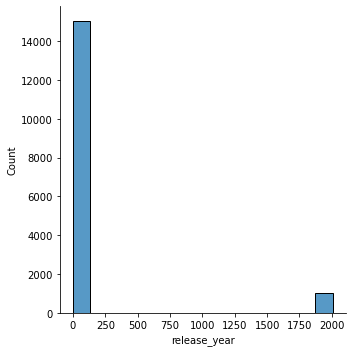

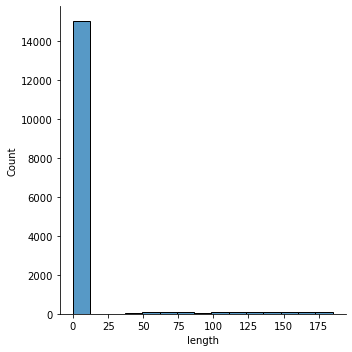

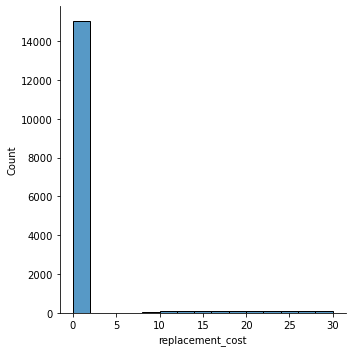

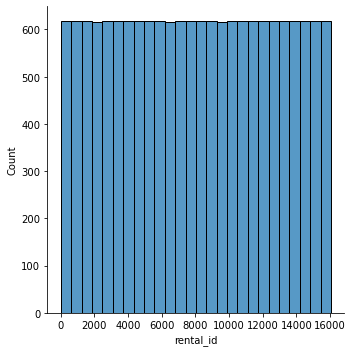

In [17]:
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()


### 4- Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable

In [18]:
#I couldnt solve this , so the bellow predictions would run trough the dataset not only based on 1 month

### 5- Create a logistic regression model to predict this variable from the cleaned data

In [19]:
y = data['rental_id']
X = data.drop('rental_id', axis=1)

In [20]:
X = pd.get_dummies(X)
X

,release_year,length,replacement_cost,title_0,title_ACADEMY DINOSAUR,title_ACE GOLDFINGER,title_ADAPTATION HOLES,title_AFFAIR PREJUDICE,title_AFRICAN EGG,title_AGENT TRUMAN,...,return_date_2005-09-02 02:19:33,return_date_2005-08-25 20:14:26,return_date_2005-08-24 17:54:40,return_date_2005-08-31 03:09:03,return_date_2005-08-25 04:08:39,return_date_2005-08-25 23:54:26,return_date_2005-08-27 18:02:47,return_date_2005-08-25 02:48:48,return_date_2005-08-31 21:33:07,return_date_2005-08-30 01:01:12
0,2006.0,86.0,20.99,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006.0,48.0,12.99,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2006.0,50.0,18.99,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2006.0,117.0,26.99,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006.0,130.0,22.99,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16039,0.0,0.0,0.00,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
16040,0.0,0.0,0.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
16041,0.0,0.0,0.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
16042,0.0,0.0,0.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
classification = LogisticRegression(random_state=42, multi_class='multinomial', max_iter=100) # this seems to be running way to long - I am suspecting its due to the way I processed the data set above.
classification.fit(X_train, y_train)

### 6- Evaluate the results (calculate the score of the model)

In [1]:
classification.score(X_test, y_test)

NameError: name 'classification' is not defined

In [ ]:
predictions = classification.predict(X_test)

pd.Series(predictions).value_counts()

NameError: name 'classification' is not defined

In [ ]:
y_test.value_counts()

In [ ]:
confusion_matrix(y_test, predictions)

In [ ]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True A', 'False A', 'False A', 'False A',
               'False B', 'True B', 'False B', 'False B',
               'False c', 'False C', 'True C', 'False C',
               'False D', 'False D', 'False D', 'True D']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')